#### Frame the Problem and Look at the Big Picture
      1. Define the objective of your project in your own words
Im Rahmen dieses Projektes soll auf Basis eines Datensatzes ein ML-Algorithmus entwickelt werden. Der Datensatz enthält unterschiedliche Sensordaten aus einem permanentmagnetischen Synchronmotor, der auf einem Prüfstand montiert ist. Als Sensordaten werden unter anderem Temperaturen im Bereich des Permanentmagneten und des Stators, der Drehmoment und die Drehzahl aufgenommen. Der Schwerpunkt der Aufgabe konzentriert sich dabei auf die Vorhersage der Magnettemperatur des Motors, wobei drei unterschiedliche Regressions-Algorithmen zu Einsatz kommen sollen.

In this project, an ML algorithm is to be developed based on a data set. The data set contains different sensor data from a permanent magnet synchronous motor, which is mounted on a test bench. Sensor data recorded include temperatures in the area of the permanent magnet and the stator, torque and speed. The main focus of the task is on the prognosis of the magnet temperature of the motor, where three different regression algorithms should be used.

    2. Select a performance criteria for evaluation of the task
Ein typisches Kriterium zur Bewertung der Performance ist der mittlere quadratische Fehler (Root Mean Sqaure Error kurz RMSE). Hier lässt sich eine Aussage darüber treffen, wie viele Fehler der Algorithmus bei der Vorhersage macht, wobei größere Fehler stärker gewichtet werden. Alternativ kann der mittlere absoulte Fehler (MAE) hinzugezogen werden.

A typical criterion for evaluating performance is the root mean square error (RMSE). Here, a statement can be made about how many errors the algorithm makes during the prediction, whereby larger errors are weighted more heavily.Alternatively, the mean absoulte error (MAE) can be used.


    3. Explain in a paragraph how you would solve the problem manually
    
  Anstelle eines ML-Algorithmus zur Vorhersage der Wärmeentwicklung des Magneten lässt sich alternativ ein detailgetreues Simulationsmodell hinzuziehen. An dem Modell können anhand von thermischen Analysen die Wärmequellen untersucht und durch die Variation von Simulationsparametern Aussagen über die Ausprägung der Wärmeentwicklung getroffen werden. Im konkreten eignet sich dafür besonders die Software-Suite Motor-CAD mit dem Entwurfsmodul "Therm", woran das thermische Verhalten (beispielsweise die Magnettemeratur bei verschiedenen Randbedingungen) des Systems analysiert werden kann.
 
 Instead of an ML algorithm for predicting the heat development of the magnet, a detailed simulation model can be used as an alternative. Thermal analyses can be carried out on the model to investigate the heat sources and, by varying the simulation parameters, statements can be made about the characteristics of the heat development. In concrete terms, the Motor-CAD software suite with the "Therm" design module is particularly suitable for this purpose, as it can be used to analyze the thermal behavior of the system (for example, the magnet temperature under various boundary conditions).


    4. List assumptions that you made so far
    
Die Aufgabenstellung verlangt konkrete Vorhersagen über die Temeratur des Permanentmagneten. Da der Alogrithmus eine kontinuierliche Größe vorhersagen soll und nicht etwa eine Klassenbezeichnung, ist die Bearbeitiung als Regressionsaufgabe als korrekt anzunehmne. 

The task requires concrete predictions about the temperature of the permanent magnet. Since the alogrithm is supposed to predict a continuous quantity and not a class designation, the processing as a regression task is to be assumed as correct.
    
    

#### Get the Data


In [1]:
# import required packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# load the data using pandas
database_electric_motor = pd.read_csv('measures_v2.csv', sep = ',')
# check data Type
print(type(database_electric_motor))
# A copy of the DataFrame "database_electric_motor" is created
database_electric_motor_copy = database_electric_motor.copy()

<class 'pandas.core.frame.DataFrame'>


The info() function prints information about the DataFrame "database_electric_motor_copy" including the number of column labels, column data types, memory usage, range index etc. As an example the storage of the column "profile_id" as int64 data type is to be mentioned here. There are over 1330000 instances in this dataset, which means that it is fairly big by Machine Learning standards. 

In [9]:
# check the size and type of the data
database_electric_motor_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


In [10]:
database_electric_motor_copy ['profile_id'].value_counts()

20    43971
6     40388
65    40094
18    37732
66    36476
      ...  
51     6261
64     6250
52     3726
46     2180
47     2176
Name: profile_id, Length: 69, dtype: int64

In [40]:
#create a test set and a train set
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

database_electric_motor_copy_with_id = database_electric_motor_copy.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(database_electric_motor_copy_with_id, 0.25, "index")

print("Lenght of test set: " + str(len(test_set)))
print("Lenght of train set: " + str(len(train_set)))

Lenght of test set: 332704
Lenght of train set: 998112


In [46]:
print (332704/1330816)

0.25


In [32]:
test_set.head(20)

,index,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
2,2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
5,5,-0.538973,18.901548,19.077108,0.009147,18.290628,0.009636,-0.613635,0.336747,24.573601,18.323862,19.850634,0.476218,17
12,12,-0.843744,18.990061,19.089575,0.732883,18.287064,0.003363,-1.866990,1.022931,24.508377,18.312222,19.902966,1.080854,17
16,16,-0.945092,18.839518,19.092737,0.801049,18.285347,-0.001452,-1.965535,1.076940,24.458145,18.330574,19.923916,1.096611,17
23,23,-0.974433,18.856869,19.099064,0.803171,18.285889,0.000163,-1.997703,1.093383,24.530256,18.301168,19.857727,1.115775,17
25,25,5.692666,18.936125,19.090200,-1.205160,18.292667,117.777489,-3.191215,11.296728,24.525579,18.303978,19.854269,2.689708,17
30,30,84.116066,18.994612,19.058531,-36.399918,18.283918,1806.124512,-13.859474,51.282242,24.430777,18.314150,19.851309,23.393009,17
35,35,93.565224,18.874516,19.053179,-78.160622,18.285549,4041.967041,-107.046577,54.131145,24.458321,18.318531,19.850750,37.013165,17
36,36,92.987953,18.846973,19.063887,-82.087227,18.322243,4313.600586,-117.414024,53.784885,24.388489,18.335131,19.850714,40.286953,17
42,42,91.976669,18.827732,19.499838,-90.350487,18.368311,4907.075195,-139.764923,52.909977,24.494350,18.442181,19.850634,47.293911,17


In [33]:
train_set.head(20)

,index,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
3,3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17
6,6,-0.653148,18.941711,19.074583,0.238890,18.292524,0.001337,-1.005647,0.554211,24.576578,18.321936,19.850630,0.670015,17
7,7,-0.758392,18.960861,19.082499,0.395099,18.294041,0.001422,-1.288384,0.706370,24.574949,18.314655,19.850628,0.752035,17
8,8,-0.727128,18.973545,19.085533,0.546623,18.291964,0.000577,-1.490530,0.817339,24.567080,18.306925,19.850626,0.910541,17
9,9,-0.874307,18.987812,19.076025,0.578944,18.287233,-0.001248,-1.634464,0.898013,24.553242,18.301733,19.850624,0.924010,17
10,10,-0.766984,18.998701,19.078054,0.689281,18.286503,0.001853,-1.739208,0.952030,24.534229,18.305416,19.850622,1.033538,17
11,11,-0.891275,19.004303,19.083162,0.680499,18.289299,-0.004142,-1.812126,0.995460,24.518921,18.303593,19.876959,1.031785,17


In [34]:
train_set.tail(20)

,index,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
1330790,1330790,-2.133406,30.721327,45.831232,0.780000,42.413012,0.000521,-2.000515,1.096097,62.320016,38.828852,24.100639,-8.901075e-57,71
1330791,1330791,-2.275122,30.721327,45.796051,0.773164,42.390463,0.001089,-2.001153,1.095895,62.298863,38.818582,24.115226,-6.377899e-57,71
1330792,1330792,-2.132231,30.721327,45.765055,0.795431,42.377546,0.003567,-1.999614,1.097335,62.274481,38.809533,24.125678,-4.569964e-57,71
1330794,1330794,-2.126554,30.721327,45.726787,0.783204,42.293915,0.001425,-2.000719,1.095404,62.241996,38.768324,24.038907,-2.346298e-57,71
1330795,1330795,-2.272478,30.721327,45.715425,0.763373,42.229104,-0.007761,-2.000772,1.096760,62.250209,38.746237,24.006360,-1.681196e-57,71
1330796,1330796,-2.155208,30.721327,45.730436,0.780442,42.166611,-0.000225,-2.000140,1.098356,62.263585,38.729330,24.018732,-1.204630e-57,71
1330797,1330797,-2.269883,30.721327,45.720934,0.787449,42.123780,-0.002981,-1.999744,1.098808,62.275998,38.716792,24.000514,-8.631548e-58,71
1330799,1330799,-2.152088,30.721327,45.628319,0.773649,42.092316,-0.000317,-2.000325,1.098142,62.264694,38.694169,24.006762,-4.431584e-58,71
1330800,1330800,-2.100234,30.721327,45.576679,0.801373,42.058240,0.007681,-2.000525,1.096536,62.260458,38.691497,24.036384,-3.175369e-58,71
1330801,1330801,-2.189709,30.720708,45.548431,0.785949,42.035313,0.000779,-1.999671,1.098788,62.241378,38.691292,24.016188,-2.275251e-58,71


In [35]:
test_set.tail(20)

,index,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
1330720,1330720,-2.176524,30.721324,47.815527,0.794415,44.249926,-0.002540,-2.000187,1.098354,62.785003,39.452222,24.013880,-1.210543e-46,71
1330727,1330727,-2.200928,30.721326,46.888233,0.767140,43.884394,0.002932,-2.001222,1.096452,62.736584,39.452280,24.040849,-1.173888e-47,71
1330729,1330729,-2.248847,30.721327,46.561208,0.759750,43.788564,0.002304,-2.001329,1.096095,62.725408,39.449751,24.040846,-6.026941e-48,71
1330734,1330734,-2.099651,30.721327,46.167880,0.809855,43.594731,0.002410,-2.001214,1.095741,62.701193,39.447941,24.060915,-1.138342e-48,71
1330738,1330738,-2.161926,30.720577,46.049921,0.782481,43.471078,0.001199,-2.001284,1.095749,62.674851,39.440698,24.046605,-3.000637e-49,71
1330741,1330741,-2.248585,30.721051,46.025475,0.781869,43.422151,-0.005053,-2.000718,1.096884,62.656290,39.439403,24.059598,-1.103873e-49,71
1330747,1330747,-2.175565,30.721289,45.991494,0.800066,43.211708,-0.003206,-2.000772,1.096052,62.587323,39.413199,23.993393,-1.493929e-50,71
1330753,1330753,-2.131886,30.721322,45.986895,0.796957,43.040786,-0.004653,-1.999200,1.099054,62.592407,39.359699,24.024891,-2.021813e-51,71
1330758,1330758,-2.270941,30.721326,45.986311,0.761375,42.946106,-0.003094,-1.999407,1.097294,62.552730,39.270427,24.007595,-3.818712e-52,71
1330760,1330760,-2.222435,30.721326,45.986245,0.763500,42.897784,-0.002809,-2.000683,1.097073,62.517002,39.253704,24.022010,-1.960592e-52,71


In [39]:
#create a training set and a validation set
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

database_electric_motor_copy_with_id = database_electric_motor_copy.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(database_electric_motor_copy_with_id, 0.1, "index")

print("Lenght of test set: " + str(len(test_set)))
print("Lenght of train set: " + str(len(train_set)))

Lenght of test set: 133081
Lenght of train set: 1197735


In [38]:
print(133081 + 1197735)

1330816


#### Explore the Data

In [49]:
# create a copy of the training set
train_set_copy = train_set.copy()
print(type(train_set_copy))

<class 'pandas.core.frame.DataFrame'>


In [50]:
#geht es dann hier um den gesamten Datensatz oder nur den Trainiungsanteil?
train_set_copy.describe()

,index,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
count,9.981120e+05,998112.000000,998112.000000,998112.000000,998112.000000,998112.000000,998112.000000,998112.000000,998112.000000,998112.000000,998112.000000,998112.000000,998112.000000,998112.000000
mean,6.654075e+05,54.277312,36.230006,66.342919,-25.133189,56.878623,2202.092876,-68.718694,37.413218,58.506765,48.188039,24.565272,31.106382,40.793047
std,3.841737e+05,44.172450,21.786129,28.672158,63.093095,22.952287,1859.687164,64.935643,92.181854,19.001516,19.991059,1.929529,77.136022,25.045518
min,0.000000e+00,-25.290930,10.623751,18.585815,-131.497238,18.161402,-271.374288,-278.003632,-293.426793,20.886429,18.076689,8.783478,-246.466663,2.000000
25%,3.327038e+05,12.069800,18.698088,42.787867,-78.736735,38.415847,317.478787,-115.413187,1.095864,43.151954,31.990248,23.184824,-0.137422,17.000000
50%,6.654075e+05,48.937037,26.900243,65.109457,-7.434929,56.036817,1999.976685,-51.073970,15.774011,60.266876,45.625129,24.797350,10.860596,43.000000
75%,9.981115e+05,90.037436,49.857442,88.141947,1.470392,75.586235,3760.948211,-2.979685,100.608269,72.008633,61.461203,26.217226,91.627459,65.000000
max,1.330815e+06,133.036994,101.598512,141.311096,131.469788,111.946423,6000.015137,0.051897,301.707855,113.606628,101.114938,30.714205,261.005707,81.000000


In [51]:
train_set_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998112 entries, 0 to 1330815
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   index           998112 non-null  int64  
 1   u_q             998112 non-null  float64
 2   coolant         998112 non-null  float64
 3   stator_winding  998112 non-null  float64
 4   u_d             998112 non-null  float64
 5   stator_tooth    998112 non-null  float64
 6   motor_speed     998112 non-null  float64
 7   i_d             998112 non-null  float64
 8   i_q             998112 non-null  float64
 9   pm              998112 non-null  float64
 10  stator_yoke     998112 non-null  float64
 11  ambient         998112 non-null  float64
 12  torque          998112 non-null  float64
 13  profile_id      998112 non-null  int64  
dtypes: float64(12), int64(2)
memory usage: 114.2 MB


In [56]:
#finding null values in the dataset by using the isnull() function
print(train_set_copy.isnull().sum())

index             0
u_q               0
coolant           0
stator_winding    0
u_d               0
stator_tooth      0
motor_speed       0
i_d               0
i_q               0
pm                0
stator_yoke       0
ambient           0
torque            0
profile_id        0
dtype: int64


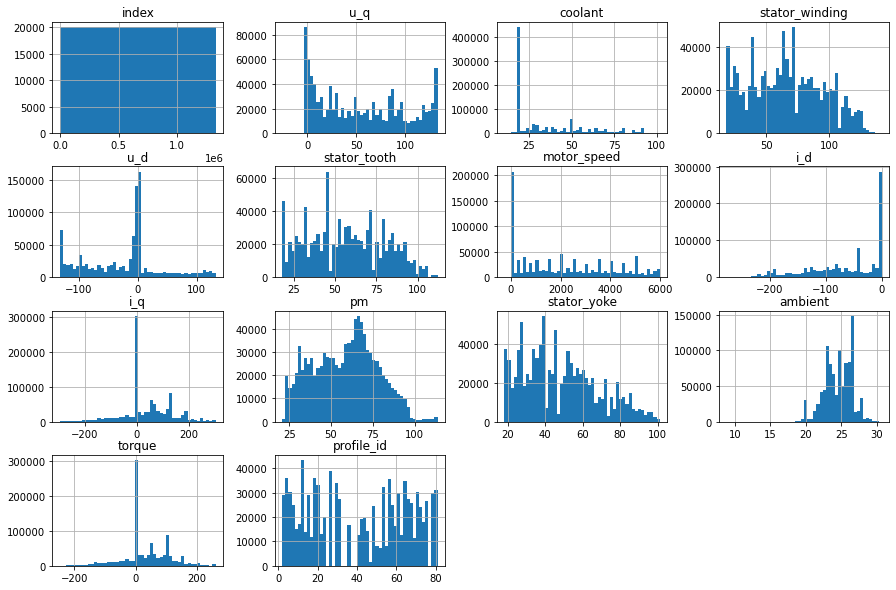

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

train_set_copy.hist(bins=50, figsize=(15,10))
plt.show()